### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import os

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
# Initialise States_tracked as 'States_track' (for convergence)
Tracked_q_values =collections.defaultdict(dict)

#States_tracked
States_tracked = [(1,10,0),(1,22,1),(4,0,0)]

In [4]:
def encode_track_action(action):
    return ('-'.join(str(e) for e in action))

In [5]:
def encode_track_state(state):
    return ('-'.join(str(e) for e in state))

In [6]:
def initialise_tracking_states():
        Tracked_state_action = [('1-10-0', '4-3'), ('1-22-1', '0-1'), ('4-0-0', '1-3'), ('4-0-0', '3-1'), ('4-0-0', '1-4'), ('4-0-0', '4-1'), ('4-0-0', '1-5'), ('4-0-0', '5-1'), ('4-0-0', '2-3'), 
                               ('4-0-0', '3-2'), ('4-0-0', '2-4'), ('4-0-0', '4-2'), ('4-0-0', '2-5'), ('4-0-0', '5-2'), ('4-0-0', '3-4'), ('4-0-0', '4-3'), ('4-0-0', '3-5'), ('4-0-0', '5-3'), 
                               ('4-0-0', '4-5'), ('4-0-0', '5-4'), ('4-0-0', '0-0')]    
        for state_action in Tracked_state_action:
            state = state_action[0]
            action = state_action[1]
            Tracked_q_values[state][action] = []

In [7]:
def save_tracking_states(curr_state, curr_action, curr_q_value):
    for state in Tracked_q_values.keys():
        if state == curr_state:
            for action in Tracked_q_values[state].keys():
                if action == curr_action:
                    Tracked_q_values[state][action].append(curr_q_value)

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
initialise_tracking_states()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.max_epsilon = 1
        self.epsilon_decay = 0.001
        self.min_epsilon = 0.00001
        self.epsilon = 1
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
                
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
        z = np.random.random()
        
        if z <= self.epsilon:
            #Exploration
            next_action_index = random.choice(possible_actions_index)
        else:
            #Exploitation
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            
            #Filter q_values for possible actions
            q_values_filtered = [q_value[0][i] for i in possible_actions_index]
            next_action_index = possible_actions_index[np.argmax(q_values_filtered)]
        return next_action_index

    def get_q_values(self, state):
        return self.model.predict(state)[0]

    def append_sample(self, state, action_index, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
            # 2. Get the target for the Q-networkfor i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            target_qval = self.model.predict(update_output)
                            
            #3. Update your 'update_output' and 'update_input' batch
            # Q Learning: get maximum Q value at s' from target model
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,epochs=1, verbose=0)
    
    def save(self, name):
        self.model.save(name)

In [11]:
Episodes = 5000
episode_time = 24*30 # end of episode
m = 5 # no. of cities
t = 24 # hours in a day
d = 7 # days in a week

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []

# make dir to store model weights
if not os.path.exists("saved_model_weights"):
    os.mkdir("saved_model_weights")

### DQN block

In [12]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    done = False
    score = 0
    env = CabDriver()
    action_space, state_space, state = env.reset()
    
    #track_state = state

    #Call the DQN agent
    
    total_time = 0
    while not done:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        next_action_index = agent.get_action(state, possible_actions_indices, actions)
        # 3 Evaluate reward and next state
        reward = env.reward_func(state, env.action_space[next_action_index], Time_matrix)
        next_state, trip_time = env.next_state_func(state, env.action_space[next_action_index], Time_matrix)
        total_time += trip_time
        score += reward
                
        if(total_time > episode_time):
            done = True
        
        #print(state, next_action_index, reward, next_state)
        agent.append_sample(state, next_action_index, reward, next_state, done)
        
        #current state to next state
        state = next_state
                       
        agent.train_model()
    
    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # save q-values for tracking convergence
    # once the episode is complete, q-values will be predicted for all possible actions for each state in global variable States_tracked
    
    for sample_state in States_tracked:
        track_state_encode = encode_track_state(sample_state)
        track_state_encoded = env.state_encod_arch1(sample_state)
        track_state_encoded = np.reshape(track_state_encoded, [1, state_size])
        track_q_values = agent.get_q_values(track_state_encoded)
    
        for index in range(len(env.action_space)):
            track_action_encode = encode_track_action(env.action_space[index])
            save_tracking_states(track_state_encode, track_action_encode, track_q_values[index])
            
    # every episode:
    if ((episode+1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    # epsilon decay
    if agent.epsilon > agent.min_epsilon:
          agent.epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.epsilon_decay*episode)
        
        
    # every few episodes:
    if ((episode+1) % 200 == 0):
        # save model weights
        #agent.save(name="model_weights.h5")
        
        #save pkl file
        save_obj(agent.model.get_weights(), "saved_model_weights/model_weights")

episode 9, reward -460.0, memory_length 1271, epsilon 0.9920319945179122
episode 19, reward -723.0, memory_length 2000, epsilon 0.9821612107479771
episode 29, reward 400.0, memory_length 2000, epsilon 0.9723886429175789
episode 39, reward -500.0, memory_length 2000, epsilon 0.9627133137617906
episode 49, reward 118.0, memory_length 2000, epsilon 0.953134255739634
episode 59, reward -726.0, memory_length 2000, epsilon 0.9436505109373241
episode 69, reward -643.0, memory_length 2000, epsilon 0.9342611309724778
episode 79, reward -178.0, memory_length 2000, epsilon 0.9249651768992738
episode 89, reward 274.0, memory_length 2000, epsilon 0.9157617191145584
episode 99, reward -135.0, memory_length 2000, epsilon 0.9066498372648834
episode 109, reward 31.0, memory_length 2000, epsilon 0.8976286201544705
episode 119, reward -674.0, memory_length 2000, epsilon 0.8886971656540912
episode 129, reward -366.0, memory_length 2000, epsilon 0.8798545806108523
episode 139, reward -167.0, memory_length 

episode 1119, reward 1069.0, memory_length 2000, epsilon 0.32693973787706004
episode 1129, reward 1335.0, memory_length 2000, epsilon 0.32368673263284237
episode 1139, reward 483.0, memory_length 2000, epsilon 0.3204660953316195
episode 1149, reward -535.0, memory_length 2000, epsilon 0.31727750390697745
episode 1159, reward 29.0, memory_length 2000, epsilon 0.3141206394971166
episode 1169, reward 553.0, memory_length 2000, epsilon 0.3109951864129652
episode 1179, reward 1056.0, memory_length 2000, epsilon 0.3079008321066102
episode 1189, reward -206.0, memory_length 2000, epsilon 0.30483726714004244
episode 1199, reward -77.0, memory_length 2000, epsilon 0.30180418515421226
episode 1209, reward -90.0, memory_length 2000, epsilon 0.29880128283839347
episode 1219, reward 1342.0, memory_length 2000, epsilon 0.2958282598998521
episode 1229, reward 1130.0, memory_length 2000, epsilon 0.2928848190338168
episode 1239, reward 600.0, memory_length 2000, epsilon 0.2899706658937479
episode 1249,

episode 2199, reward 958.0, memory_length 2000, epsilon 0.1110338761833224
episode 2209, reward 948.0, memory_length 2000, epsilon 0.10992917015748652
episode 2219, reward 1068.0, memory_length 2000, epsilon 0.10883545614026607
episode 2229, reward 234.0, memory_length 2000, epsilon 0.10775262475934778
episode 2239, reward -82.0, memory_length 2000, epsilon 0.10668056773069129
episode 2249, reward 523.0, memory_length 2000, epsilon 0.10561917784770025
episode 2259, reward 1609.0, memory_length 2000, epsilon 0.10456834897050199
episode 2269, reward -501.0, memory_length 2000, epsilon 0.10352797601533296
episode 2279, reward 78.0, memory_length 2000, epsilon 0.10249795494403079
episode 2289, reward 678.0, memory_length 2000, epsilon 0.10147818275362988
episode 2299, reward -135.0, memory_length 2000, epsilon 0.1004685574660615
episode 2309, reward 217.0, memory_length 2000, epsilon 0.09946897811795544
episode 2319, reward -1000.0, memory_length 2000, epsilon 0.09847934475054392
episode 2

episode 3279, reward 1304.0, memory_length 2000, epsilon 0.03771321159161401
episode 3289, reward 12.0, memory_length 2000, epsilon 0.03733805836808715
episode 3299, reward 645.0, memory_length 2000, epsilon 0.03696663798150393
episode 3309, reward 1388.0, memory_length 2000, epsilon 0.036598913289516144
episode 3319, reward -452.0, memory_length 2000, epsilon 0.0362348475193482
episode 3329, reward 1192.0, memory_length 2000, epsilon 0.035874404264119635
episode 3339, reward 1204.0, memory_length 2000, epsilon 0.03551754747920461
episode 3349, reward 51.0, memory_length 2000, epsilon 0.03516424147862722
episode 3359, reward 382.0, memory_length 2000, epsilon 0.034814450931492984
episode 3369, reward 1001.0, memory_length 2000, epsilon 0.03446814085845571
episode 3379, reward 1339.0, memory_length 2000, epsilon 0.03412527662821948
episode 3389, reward 67.0, memory_length 2000, epsilon 0.03378582395407558
episode 3399, reward 1102.0, memory_length 2000, epsilon 0.03344974889047369
episo

episode 4349, reward 1196.0, memory_length 2000, epsilon 0.012942522709963319
episode 4359, reward 932.0, memory_length 2000, epsilon 0.012813841958956525
episode 4369, reward 90.0, memory_length 2000, epsilon 0.012686441602815523
episode 4379, reward 138.0, memory_length 2000, epsilon 0.012560308901398549
episode 4389, reward 233.0, memory_length 2000, epsilon 0.01243543124133034
episode 4399, reward 768.0, memory_length 2000, epsilon 0.012311796134740824
episode 4409, reward 1015.0, memory_length 2000, epsilon 0.012189391218016302
episode 4419, reward 868.0, memory_length 2000, epsilon 0.01206820425056312
episode 4429, reward -37.0, memory_length 2000, epsilon 0.01194822311358353
episode 4439, reward 1275.0, memory_length 2000, epsilon 0.011829435808863854
episode 4449, reward -20.0, memory_length 2000, epsilon 0.011711830457574613
episode 4459, reward 981.0, memory_length 2000, epsilon 0.011595395299082701
episode 4469, reward 195.0, memory_length 2000, epsilon 0.011480118689775222


### Tracking Convergence

Text(0, 0.5, 'reward per episode')

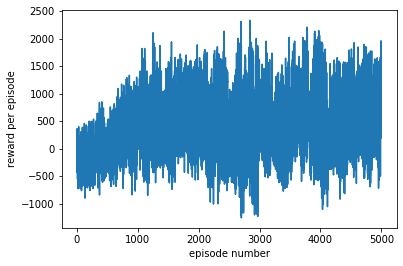

In [13]:
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")


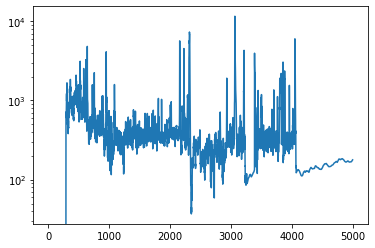

In [18]:
# State-action q-value graph
values = Tracked_q_values['4-0-0']['4-3']
plt.yscale('log')
plt.plot(values)

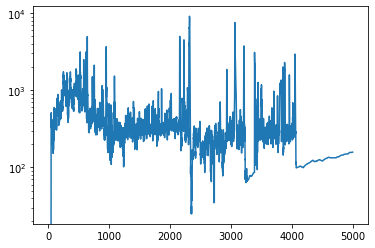

In [19]:
# State-action q-value graph
values = Tracked_q_values['4-0-0']['3-1']
plt.yscale('log')
plt.plot(values)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

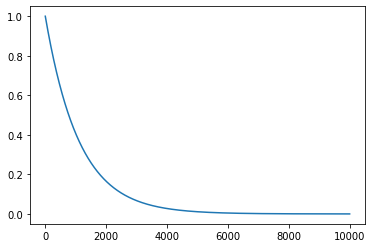

In [17]:
plt.plot(time, epsilon)
plt.show()